# Data Cleaning, Preprocessing, and Disaggregation using NILMTK
This Jupyter Notebook focuses on cleaning, preprocessing, and appliance-level disaggregation of energy consumption data using the NILMTK library.

In [13]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import datetime, time
import sklearn
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nilmtk.metrics import f1_score
from nilmtk.disaggregate import Mean
from nilmtk.legacy.disaggregate import FHMM
from nilmtk import DataSet
from nilmtk.utils import get_datastore
import nilmtk
from hmmlearn import hmm
from nilmtk import DataSet, HDFDataStore
from nilmtk.legacy.disaggregate import fhmm_exact
from os.path import join
housedata = pd.read_csv("data_30_minutes.csv")
house_london = pd.read_csv("30_minutes.csv")


## Reading Energy Consumption Data
The energy consumption data from Both Paul's house data and the london Kaggle data are becoming into one DataFrame. This is in an attempt to increase the amount of data that can be used and, the assumption here is that the energy usage is similar for the london houses and Pauls house. 

In [2]:
housedata.reset_index(drop=True,inplace=True)
house_london.reset_index(drop=True, inplace = True)
df1 = housedata.append(house_london)

C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\pandas\core\frame.py:7134: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return concat(


In [3]:
print(df1)

             LCLid  Unnamed: 0      energy                       tstp
0              NaN           0  515.333333  2022-11-30 17:12:00+00:00
1              NaN           1  228.590909  2022-11-30 17:16:00+00:00
2              NaN           2  184.708333  2022-11-30 17:20:00+00:00
3              NaN           3  349.040000  2022-11-30 17:24:00+00:00
4              NaN           4  362.125000  2022-11-30 17:28:00+00:00
...            ...         ...         ...                        ...
1222615  MAC005492     1222665  182.000000        2014-02-27 22:00:00
1222616  MAC005492     1222666  122.000000        2014-02-27 22:30:00
1222617  MAC005492     1222667  140.000000        2014-02-27 23:00:00
1222618  MAC005492     1222668  192.000000        2014-02-27 23:30:00
1222619  MAC005492     1222669   88.000000        2014-02-28 00:00:00

[2150481 rows x 4 columns]


In [4]:
print(df1.columns)
print(df1.isnull().sum())
df2 = df1.drop(columns=["Unnamed: 0"])

Index(['LCLid', 'Unnamed: 0', 'energy', 'tstp'], dtype='object')
LCLid         927861
Unnamed: 0         0
energy             0
tstp               0
dtype: int64


In [5]:
print(df2)
print(df2.dtypes)

             LCLid      energy                       tstp
0              NaN  515.333333  2022-11-30 17:12:00+00:00
1              NaN  228.590909  2022-11-30 17:16:00+00:00
2              NaN  184.708333  2022-11-30 17:20:00+00:00
3              NaN  349.040000  2022-11-30 17:24:00+00:00
4              NaN  362.125000  2022-11-30 17:28:00+00:00
...            ...         ...                        ...
1222615  MAC005492  182.000000        2014-02-27 22:00:00
1222616  MAC005492  122.000000        2014-02-27 22:30:00
1222617  MAC005492  140.000000        2014-02-27 23:00:00
1222618  MAC005492  192.000000        2014-02-27 23:30:00
1222619  MAC005492   88.000000        2014-02-28 00:00:00

[2150481 rows x 3 columns]
LCLid      object
energy    float64
tstp       object
dtype: object


In [6]:
df2['tstp'] = pd.to_datetime(df2['tstp'], utc=True)
date_str = '2023-01-02 00:00:00+00:00'
date = pd.to_datetime(date_str)
daily_data = {}
for day, data in df2.groupby(df2['tstp'].dt.date):
    daily_data[day] = data
#In order to get a database based on the day, just need to do daily_data['date']
df3 = daily_data[date.date()]
print(df3)
dftest = df3.reset_index().set_index("LCLid")
dftest = dftest.drop(columns=["index"])
print(dftest)

       LCLid  energy                      tstp
361      NaN  250.00 2023-01-02 17:31:03+00:00
362      NaN  251.00 2023-01-02 17:31:12+00:00
363      NaN  250.00 2023-01-02 17:31:24+00:00
364      NaN  251.00 2023-01-02 17:31:33+00:00
365      NaN  252.00 2023-01-02 17:31:42+00:00
...      ...     ...                       ...
371946   NaN   39.65 2023-01-02 23:38:59+00:00
371947   NaN   39.65 2023-01-02 23:43:59+00:00
371948   NaN   39.65 2023-01-02 23:48:59+00:00
371949   NaN   39.65 2023-01-02 23:53:59+00:00
371950   NaN   39.65 2023-01-02 23:58:59+00:00

[3573 rows x 3 columns]
       energy                      tstp
LCLid                                  
NaN    250.00 2023-01-02 17:31:03+00:00
NaN    251.00 2023-01-02 17:31:12+00:00
NaN    250.00 2023-01-02 17:31:24+00:00
NaN    251.00 2023-01-02 17:31:33+00:00
NaN    252.00 2023-01-02 17:31:42+00:00
...       ...                       ...
NaN     39.65 2023-01-02 23:38:59+00:00
NaN     39.65 2023-01-02 23:43:59+00:00
NaN     39.

## Preprocessing Data
The energy consumption data is plotted using Matplotlib, and the z-scores are measured to remove outliers. The data is preprocessed by transforming the timestamp data into Unix time and scaling the energy consumption data using StandardScaler from Scikit-learn.

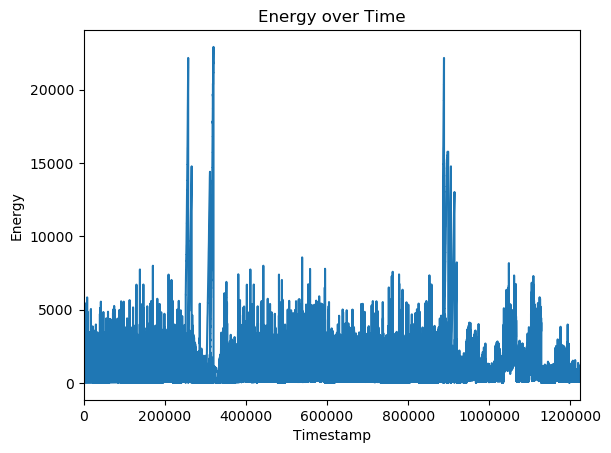

In [7]:
df2['energy'].plot()
plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.title('Energy over Time')
plt.show()

Text(0.5, 1.0, 'Energy over Time')

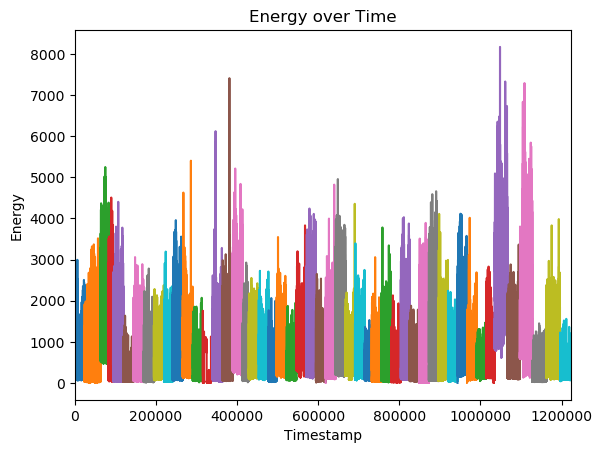

In [8]:
grouped = df2.groupby('LCLid')

fig, ax = plt.subplots()
for key, group in grouped:
    group['energy'].plot(ax=ax, label=key)

plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.title('Energy over Time')


In [9]:
df2['tstp'] = pd.to_datetime(df2['tstp'], utc=True)
#transform the timestates to Unix Time, seconds from January 1,1970
df2['unix_time'] = df2['tstp'].astype(np.int64) // 10**9
df4 = df2.drop(columns=["LCLid", "tstp"])
# to measure the z scores to remove outliers 
z = np.abs(stats.zscore(df4))
df5 = df4[(z < 3).all(axis=1)]
print(df5.shape)
print(df5)
df6 = df5.loc[:, ['energy', 'unix_time']]
df6['energy'] = df6['energy'].fillna(0)
#to transform data to have 
scaler = StandardScaler()
df6.loc[:, "energy"] = scaler.fit_transform(df6.loc[:, ["energy"]])



(2107657, 2)
             energy   unix_time
0        515.333333  1669828320
1        228.590909  1669828560
2        184.708333  1669828800
3        349.040000  1669829040
4        362.125000  1669829280
...             ...         ...
1222615  182.000000  1393538400
1222616  122.000000  1393540200
1222617  140.000000  1393542000
1222618  192.000000  1393543800
1222619   88.000000  1393545600

[2107657 rows x 2 columns]


In [10]:
print(df6)

train_df, test_df = train_test_split(df6, test_size=0.2)

           energy   unix_time
0        0.047759  1669828320
1       -0.352695  1669828560
2       -0.413980  1669828800
3       -0.184480  1669829040
4       -0.166206  1669829280
...           ...         ...
1222615 -0.417762  1393538400
1222616 -0.501556  1393540200
1222617 -0.476417  1393542000
1222618 -0.403796  1393543800
1222619 -0.549039  1393545600

[2107657 rows x 2 columns]


In [16]:
ukdale = nilmtk.DataSet('archive/ukdale.h5/ukdale.h5/ukdale.h5')
print(ukdale)
building = ukdale.buildings[1]
metadata = building.metadata
print(metadata)

{'description': 'Some individual appliance meters are switched off from the socket for significant portions of time.  These include (using original names): laptop, kettle, toaster, lcd_office, hifi_office, livingroom_s_lamp, soldering_iron, gigE_&_USBhub, hoover, iPad_charger, utilityrm_lamp, hair_dryer, straighteners, iron, childs_ds_lamp, office_lamp3, office_pc, gigE_switch', 'description_of_occupants': '2 adults and 1 dog started living in the house in 2006 (i.e. before the dataset started recording).  One child born 2011-08-27 and a second child born 2014-04-27.', 'original_name': 'house_1', 'heating': ['natural gas'], 'instance': 1, 'building_type': 'end of terrace', 'energy_improvements': ['solar thermal', 'loft insulation', 'solid wall insulation', 'double glazing'], 'rooms': [{'name': 'lounge', 'floor': 0}, {'instance': 1, 'name': 'hall', 'floor': 0}, {'instance': 2, 'name': 'hall', 'floor': 1}, {'name': 'kitchen', 'floor': 0}, {'name': 'utility', 'floor': 0}, {'name': 'dining

In [22]:
building = ukdale.buildings[1]

## Disaggregating Energy Consumption Data
The first attempt at using NILMTK to disaggregate the energy consumption data into individual appliances using the FHMM algorithm. This is done on the UKdale data first as the data is best suited for the toolkit, however my Laptop does not have enough memory to withstand the training. Finally, the model is tested, and its performance is meant to be evaluated using the f1_score.

In [23]:
train = ukdale.buildings[1].elec
test = dftest

In [ ]:
model = fhmm_exact.FHMM()
model.train(train)
output = model.disaggregate(test)

# Test the model and evaluate its performance
f1 = nilmtk.metrics.f1_score(output, test)
print('F1 score:', f1)

C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\nilmtk\legacy\disaggregate\fhmm_exact.py:192: UserWarning: The required memory for the model may be more than the total system memory! Try using fewer appliances if the training fails.
  warn("The required memory for the model may be more than the total system memory!"
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=2, building=1, dataset='UK-DALE', appliances=[Appliance(type='boiler', instance=1)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=3, building=1, dataset='UK-DALE', appliances=[Appliance(type='solar thermal pumping station', instance=1)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=4, building=1, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1), Appliance(type='laptop computer', instance=3)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=5, building=1, dataset='UK-DALE', appliances=[Appliance(type='washer dryer', instance=1)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=6, building=1, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=7, building=1, dataset='UK-DALE', appliances=[Appliance(type='television', instance=1)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=8, building=1, dataset='UK-DALE', appliances=[Appliance(type='light', instance=1), Appliance(type='light', instance=2)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=9, building=1, dataset='UK-DALE', appliances=[Appliance(type='HTPC', instance=1)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=10, building=1, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1), Appliance(type='food processor', instance=1), Appliance(type='toasted sandwich maker', instance=1)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=11, building=1, dataset='UK-DALE', appliances=[Appliance(type='toaster', instance=1), Appliance(type='kitchen aid', instance=1), Appliance(type='food processor', instance=2)])' with 2 states


C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ricky\anaconda3\envs\nilmtk\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=12, building=1, dataset='UK-DALE', appliances=[Appliance(type='fridge freezer', instance=1)])' with 2 states
